# Лабораторная работа 2 : «Наивный» байесовский классификатор

In [1]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as qda
from sklearn.linear_model import LogisticRegression as lr
from sklearn import svm
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import itertools
import sklearn
from scipy import linalg as npl
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import OrdinalEncoder

In [2]:
### methods

def GetProbByColumn(X_, y_, column, j, alpha = 0):
    prob  = {}
    x = X_[column]
    x = x[y_ == j]
    unique = X_[column].unique()
    k = len(unique)
    for i in unique:
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def Predict2(X_, y_, column):
    yPred = []
    prob0 = GetProbByColumn(X_, y_, column, 'e')
    prob1 = GetProbByColumn(X_, y_, column, 'p')
    c = y_.count()
    p0 = y_[y_ == 'e'].count() / c
    p1 = y_[y_ == 'p'].count() / c
    for k in X_[column]:
        if p0 * prob0[k] < p1 * prob1[k]:
            yPred.append('p')
        else:
            yPred.append('e')
    return np.array(yPred)

def GetProbs(X_, y_, j, alpha):
    probs = {}
    for col in X_.columns:
        probs[col] = (GetProbByColumn(X_, y_, col, j, alpha))
    return probs

def Predict4(X_, y_, alpha):
    y_pred = []
    prob0 = GetProbs(X_, y_, 'e', alpha)
    prob1 = GetProbs(X_, y_, 'p', alpha)
    c = y_.count()
    p0 = y_[y_ == 'e'].count() / c
    p1 = y_[y_ == 'p'].count() / c
    for i in range(len(X_)):
        p0_ = p0
        p1_ = p1
        for col in X_.columns:
            p0_ *= prob0[col][X_[i:i+1][col].values[0]]
            p1_ *= prob1[col][X_[i:i+1][col].values[0]]
        if p0 * p0_ < p1 * p1_:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return y_pred

## Задание 1

In [3]:
# V=83 => вариант 12

df = pd.read_csv('mushrooms.csv')
df = df[['stalk-surface-above-ring', 'stalk-surface-below-ring','stalk-color-above-ring', 'stalk-color-below-ring','veil-type','class']]
X = df.drop(columns=['class'])
y = df['class']
df

,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,class
0,s,s,w,w,p,p
1,s,s,w,w,p,e
2,s,s,w,w,p,e
3,s,s,w,w,p,p
4,s,s,w,w,p,e
...,...,...,...,...,...,...
8119,s,s,o,o,p,e
8120,s,s,o,o,p,e
8121,s,s,o,o,p,e
8122,s,k,w,w,p,p


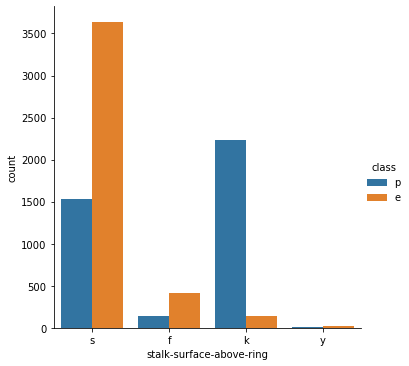

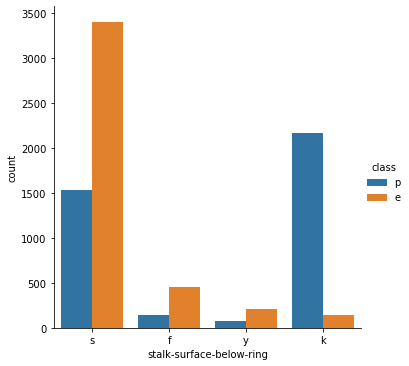

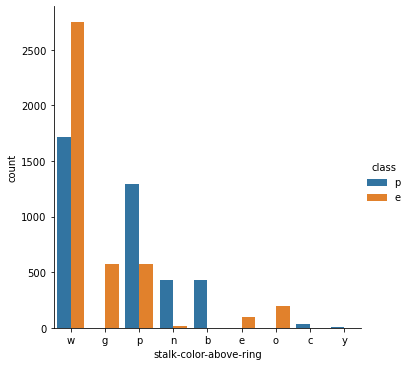

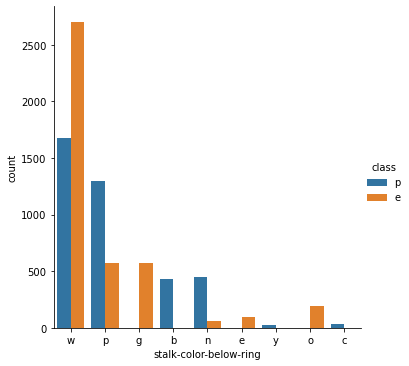

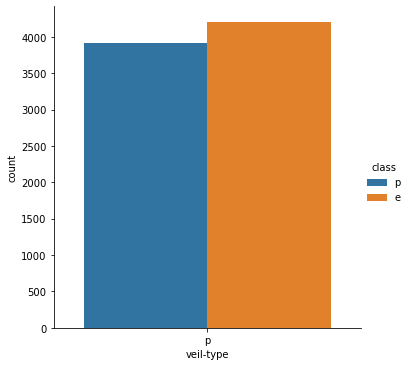

In [4]:
for i in X:
    sns.catplot(x = i, data=df, hue='class',kind = 'count' )

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)

## Задание 2

In [6]:
G = pd.DataFrame(columns = ['score_test','score_train'])
for col in X.columns:
    G = G.append({'score_test' : accuracy_score(y_test, Predict2(X_test, y_test, col)), 'score_train' : accuracy_score(y_train, Predict2(X_train, y_train, col))},ignore_index=True)
G = G.set_index(X.columns)
G

,score_test,score_train
stalk-surface-above-ring,0.769079,0.776301
stalk-surface-below-ring,0.766617,0.765961
stalk-color-above-ring,0.707041,0.719514
stalk-color-below-ring,0.705564,0.717381
veil-type,0.500739,0.523716


видно, что самая информативная переменная - **stalk-surface-above-ring**

## Задание 3

In [39]:
#y_ohe = y.copy()
#y_ohe = LabelEncoder().fit_transform(y_ohe)

#X_ohe = X.copy()
#X_ohe['veil-type']=LabelEncoder().fit_transform(X_ohe['veil-type'])
#X_ohe = pd.get_dummies(data=X_ohe)

#X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, random_state=1234)

X_train_ohe = pd.get_dummies(X_train)
X_test_ohe = pd.get_dummies(X_test)
y_train_ohe = y_train
y_test_ohe = y_test

model = sklearn.naive_bayes.BernoulliNB()
model.fit(X_train_ohe,y_train_ohe)
score = model.score(X_test_ohe,y_test_ohe)
print('Score:', score)

Score: 0.8129000492368291


## Задание 4

In [41]:
def pred(X_, col): 
    l_0 = 0
    b_0 = 0
    for j in X_.columns:
        b_j =0
        b_j = np.log(p[j]*(1-q[j])/(q[j]*(1-p[j])))
        l_0+=b_j*col[j]
        b_0+=np.log((1-p[j])/(1-q[j]))
    b_0 += np.log(P1/P2)
    return (l_0+b_0)

def Predict4task(X_, y_, X_tr, y_tr):
    p = {}
    q = {}
    y_tr_len = len(y_tr)
    P1 = len(y_tr[y_tr=='p'])/y_tr_len
    P2 = len(y_tr[y_tr=='e'])/y_tr_len
    for j in X_tr.columns:
        p[j] = (X_tr[y_tr=='p'][j].mean())
        q[j] = (X_tr[y_tr=='e'][j].mean())
        if(q[j]==1):
            q[j] = 1.-1e-10
        if(p[j]==1):
            p[j] = 1.-1e-10
        if(q[j]==0):
            q[j] = 1e-20
        if(p[j]==0):
            p[j] = 1e-20
    a = []
    for i in X_.index:
        a.append(pred(X_, X_.loc[i]))
    b = []
    for i in a:
        if(i>=0):
            b.append('p')
        else:
            b.append('e')
    b = np.array(b)
    err = 0
    for i in range(len(b)):
        if(b[i]!=y_.iloc[i]):
            err+=1
    score = 1- err/len(b)
    return score

In [42]:
print('Score:', Predict4task(X_test_ohe, y_test_ohe, X_train_ohe, y_train_ohe))

Score: 0.8129000492368291


видно, что результат совпадает с библиотечным методом

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)

print('test:', accuracy_score(Predict4(X_test, y_test, 1), y_test))
print('train:', accuracy_score(Predict4(X_train, y_train, 1), y_train))

test: 0.811422944362383
train: 0.804693911045462


In [9]:
X_o = X.copy()
y_o = y.copy()
enc = OrdinalEncoder()
X_o = enc.fit_transform(X_o)
y_o =  enc.fit_transform(pd.DataFrame(y_o))
X_train, X_test, y_train, y_test = train_test_split(X_o, y_o, random_state=1234)
print(y_train)
model = sklearn.naive_bayes.CategoricalNB().fit(X_train,y_train)
print('test:', accuracy_score(y_test, model.predict(X_test)))
print('train:', accuracy_score(y_train, model.predict(X_train)))

X_c = X.copy()
y_c = y.copy()
for i in X_c:
    X_c[i]=LabelEncoder().fit_transform(df[i])
y_c = LabelEncoder().fit_transform(y_c)
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c,random_state=1234)
print(y_train)
model = sklearn.naive_bayes.CategoricalNB().fit(X_train,y_train)
print('test:', accuracy_score(y_test, model.predict(X_test)))
print('train:', accuracy_score(y_train, model.predict(X_train)))

y_ohe = y.copy()
y_ohe = LabelEncoder().fit_transform(y_ohe)
X_ohe = X.copy()
X_ohe['veil-type']=LabelEncoder().fit_transform(X_ohe['veil-type'])
X_ohe = pd.get_dummies(data=X_ohe)
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y_ohe, random_state=1234)
print(y_train)
model = sklearn.naive_bayes.BernoulliNB().fit(X_train,y_train)
print('test:', accuracy_score(y_test, model.predict(X_test)))
print('train:', accuracy_score(y_train, model.predict(X_train)))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
print(y_train)
print('test:', accuracy_score(Predict4(X_test, y_test, 1), y_test))
print('train:', accuracy_score(Predict4(X_train, y_train, 1), y_train))

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
test: 0.809945839487937
train: 0.804693911045462
[0 1 0 ... 0 0 0]
test: 0.809945839487937
train: 0.804693911045462
[0 1 0 ... 0 0 0]
test: 0.8129000492368291
train: 0.8155260134580666
1511    e
6049    p
2041    e
1524    e
2993    e
       ..
3276    p
7221    e
1318    e
723     e
2863    e
Name: class, Length: 6093, dtype: object


C:\Users\111\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


test: 0.811422944362383
train: 0.804693911045462


In [10]:
def get_prob_col(X,y,column,j, alpha = 0):
    prob  = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def get_prob(X,y,j,alpha = 0):
    prob = {}
    for col in X.columns:
        prob[col] = (get_prob_col(X,y,col,j,alpha))
    return prob

def predict(X,y, alpha = 0):
    prob0 = get_prob(X,y,'e',alpha= alpha)
    prob1 = get_prob(X,y,'p',alpha = alpha)
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    y_pred = []
    for i in range(len(X)):
        prod0 = p0
        prod1 = p1
        for col in X.columns:
            prod0 *= prob0[col][X[i:i+1][col].values[0]]
            prod1 *= prob1[col][X[i:i+1][col].values[0]]
        if p0 * prod0 < p1 * prod1:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return y_pred

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1234)
print('test:',accuracy_score(predict(X_test,y_test, alpha= 1), y_test))
print('train:',accuracy_score(predict(X_train,y_train, alpha= 1), y_train))

test: 0.811422944362383
train: 0.804693911045462


In [11]:
def get_prob_col1(column,j, alpha = 0):
    prob  = {}
    x = X[column]
    x = x[y == j]
    k = len(X[column].unique())
    for i in X[column].unique():
        prob[i] = (x[x == i].count() + alpha) / (x.count() + alpha * k)
    return prob

def predict1(X,column):
    print('aaa')
    y_pred = []
    prob0 = get_prob_col1(column,'e')
    prob1 = get_prob_col1(column,'p')
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    for k in X[column]:
        if p0 * prob0[k] < p1 * prob1[k]:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return np.array(y_pred)

def get_prob1(j,alpha = 0):
    prob = {}
    for col in X.columns:
        prob[col] = (get_prob_col1(col,j,alpha))
    return prob

def predict1(X, alpha = 0):
    prob0 = get_prob1('e',alpha= alpha)
    prob1 = get_prob1('p',alpha = alpha)
    p0 = y[y == 'e'].count() / y.count()
    p1 = y[y == 'p'].count() / y.count()
    y_pred = []
    for i in range(len(X)):
        prod0 = p0
        prod1 = p1
        for col in X.columns:
            prod0 *= prob0[col][X[i:i+1][col].values[0]]
            prod1 *= prob1[col][X[i:i+1][col].values[0]]
        if p0 * prod0 < p1 * prod1:
            y_pred.append('p')
        else:
            y_pred.append('e')
    return y_pred

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1234)
print('test:',accuracy_score(predict1(X_test, alpha= 1), y_test))
print('train:',accuracy_score(predict1(X_train, alpha= 1), y_train))

test: 0.811422944362383
train: 0.8061710159199081
